<a href="https://colab.research.google.com/github/Rodrigoveloso7/dimensionamento-isolamento-tubula-es-de-refrigera-o/blob/main/dimensionamento_isolamento_suc_o_e_l_quido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install CoolProp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 39.9 MB/s eta 0:00:00


In [ ]:
pip install ht

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.5/608.5 kB 37.5 MB/s eta 0:00:00


In [ ]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import ht as ht
import matplotlib.pyplot as plt


In [ ]:
#Dados geométricos
raio_ext_succao = (10e-3)/2 # raio externo tubulação [m]
raio_ext_liquido = (6.35e-3)/2 # raio externo tubulação [m]
L_liquido = 20 # comprimento da tubulação [m]

#Propriedades físicas dos elementos
k_tubo = 370 # condutividade térmica tubulação [W/mK]
k_iso = 0.1 # condutividade térmica isolante [W/mK] a 40°C

#Propriedades do escoamento e ambientais
T_int_succao = 273.15+3 # Temperatura do fluido interno [K]
T_int_liquido = 273.15+30 # Temperatura do fluido interno [K]
subresfriamento = 4
Pressao_succao = 345000 # Pressão do fluido interno [Pa]
Pressao_liquido = 1.27e6 # Pressão do fluido interno [Pa]
T_amb = 273.15+40# Temperatura ambiente [K]
P_amb = 101325
UR = 0.7 # Umidade relativa [-]
g = 9.81 # Aceleração da gravidade [m/s²]
vazao = 0.1


#Função para determinação de espessura de isolante na linha de sucção

In [ ]:
def linha_succao(raio_ext,UR,T_amb,T_int):
  #Definição temperatura de orvalho
  P_vapor_agua = UR*PropsSI('P', 'T', T_amb, 'Q', 1, 'Water')
  T_orvalho = PropsSI('T', 'P', P_vapor_agua, 'Q', 1, 'Water')
  T_sup = T_orvalho+2
  # T_evap_linha_liquido = PropsSI('T', 'P', Pressao_liquido, 'Q', 0, 'R290')
  # T_int = T_evap_linha_liquido-2
  # T_sup = T_evap_linha_liquido+1
  print('T_amb',T_amb)
  print('T_int',T_int)
  print('T_sup',T_sup)

  r2_temp = raio_ext+0.01
  for i in np.arange(1,100,1):
    def h_conv(r2_temp):
      T_filme = (T_sup+T_amb)/2
      bheta = 1 / T_filme
      visc_din = PropsSI('V', 'T', T_filme, 'P', 101325, 'Air')
      densidade = PropsSI('D', 'T', T_filme, 'P', 101325, 'Air')
      visc_cin = visc_din/densidade
      k_ar = PropsSI('L', 'T', T_filme, 'P', 101325, 'Air')
      cp = PropsSI('C', 'T', T_filme, 'P', 101325, 'Air')
      Gr = ((g*bheta*(T_amb-T_sup)*((r2_temp*2)**3))/(visc_cin**2))
      Pr = (visc_din*cp)/k_ar
      print('r2_temp',r2_temp)
      print('Gr',Gr)
      print('Pr',Pr)
      Nu = ht.conv_free_immersed.Nu_horizontal_cylinder_Churchill_Chu(Pr,Gr)
      return ((Nu*k_ar)/((r2_temp*2)))
    h = h_conv(r2_temp)
    r2 = ((k_iso*(T_sup-T_int))/(np.log(r2_temp/raio_ext)*h*(T_amb-T_sup)))

    if abs(r2-r2_temp)<(1e-4):
      #print(r2-r2_temp)
      break
    r2_temp = r2


  espessura = (r2-raio_ext)*1000
  perda_calor_linear = (T_amb - T_int) / ((np.log(r2 / raio_ext) / (2 * np.pi * k_iso)) + (1 / (2 * np.pi * r2 * h)))
  # perda_calor_linear = (T_amb - T_int_succao) / ( (1 / (2 * np.pi * raio_ext_succao * 50)))
  rc = k_iso/h

  # print('Raio crítico {} [mm]'.format(rc*1000))


  lista_perda_calor = []
  r2_lista = np.linspace(raio_ext,raio_ext*100,1000)
  espessura_lista = []
  for r2 in r2_lista:
    h = h_conv(r2)
    lista_perda_calor.append((T_amb - T_int) / ((np.log(r2 / raio_ext) / (2 * np.pi * k_iso)) + (1 / (2 * np.pi * r2 * h))))
    espessura_lista.append((r2-raio_ext)*1000)
  plt.plot(espessura_lista,lista_perda_calor,color='black')
  plt.title('Perda de calor linear x Espessura \n Linha de sucção')
  plt.xlabel('Espessura [mm]')
  plt.ylabel('Perda de calor linear [W/m]')
  plt.grid()
  plt.show()
  print( 'Temperatura de orvalho {} [°C]'.format(T_orvalho -273.15))
  print('Coeficiente convectivo {} [W/mK]'.format(h))
  print('Perda de calor linear {} [W/m]'.format(perda_calor_linear))
  print('Espessura da linha de sucção {} [mm]'.format(espessura))

  return #print(espessura)

In [ ]:
def linha_liquido(raio_ext,UR,T_amb,Pressao_liquido,vazao,L,subresfriamento):
  T_sat_cond = PropsSI('T', 'P', Pressao_liquido, 'Q', 0, 'R290')
  T_int = T_sat_cond-subresfriamento
  if T_amb < T_int:
    return print('Não é necessário isolamento')

  print('T_amb',T_amb)
  print('T_int',T_int)
  q= 20

  r2_temp = raio_ext+(raio_ext/10)
  print('primeiro',r2_temp)
  lista_r2_temp = np.linspace(raio_ext+(raio_ext/10),raio_ext*100,100)
  T_sup = (T_int +T_amb) / 2
  for r2_temp in lista_r2_temp:
    def h_conv(r2_temp):
      T_filme = (T_sup+T_amb)/2
      bheta = 1 / T_filme
      visc_din = PropsSI('V', 'T', T_filme, 'P', 101325, 'Air')
      densidade = PropsSI('D', 'T', T_filme, 'P', 101325, 'Air')
      visc_cin = visc_din/densidade
      k_ar = PropsSI('L', 'T', T_filme, 'P', 101325, 'Air')
      cp = PropsSI('C', 'T', T_filme, 'P', 101325, 'Air')
      Gr = ((g*bheta*(T_amb-T_sup)*((r2_temp*2)**3))/(visc_cin**2))
      Pr = (visc_din*cp)/k_ar
      # print('r2_temp',r2_temp)
      # print('Gr',Gr)
      # print('Pr',Pr)
      Nu = ht.conv_free_immersed.Nu_horizontal_cylinder_Churchill_Chu(Pr,Gr)
      return ((Nu*k_ar)/((r2_temp*2)))
    h = h_conv(r2_temp)
    # r2 = ((k_iso*(T_sup-T_int))/(np.log(r2_temp/raio_ext)*h*(T_amb-T_sup)))
    q_adm = vazao*PropsSI('C', 'P', Pressao_liquido, 'Q', 0, 'R290')*(subresfriamento)/L
    # q_adm =0.4
    q = ((T_amb-T_int)/((1/(2*np.pi))*(((np.log(r2_temp/raio_ext)/k_iso)+(1/(r2_temp*h))))))
    T_sup = T_int + (q * np.log(r2_temp/raio_ext)) / (2 * np.pi * k_iso)

    if q<=q_adm:
      r2 = r2_temp
      print('qdm',q_adm)
      break



  espessura = (r2-raio_ext)*1000
  perda_calor_linear = (T_amb - T_int) / ((np.log(r2 / raio_ext) / (2 * np.pi * k_iso)) + (1 / (2 * np.pi * r2 * h)))
  # perda_calor_linear = (T_amb - T_int_succao) / ( (1 / (2 * np.pi * raio_ext_succao * 50)))
  rc = k_iso/h

  lista_perda_calor = []
  espessura_lista = []
  for r2 in (lista_r2_temp):
    h = h_conv(r2)
    espessura_lista.append((r2-raio_ext)*1000)
    # print('r2',r2)
    # print('raio_ext',raio_ext)
    lista_perda_calor.append((T_amb - T_int) / ((np.log(r2 / raio_ext) / (2 * np.pi * k_iso)) + (1 / (2 * np.pi * r2 * h))))
  plt.plot(espessura_lista,lista_perda_calor,color='black')
  plt.title('Perda de calor linear x Espessura \n Linha de líquido')
  plt.xlabel('Espessura [mm]')
  plt.ylabel('Perda de calor linear [W/m]')
  plt.grid()
  plt.show()
  # print(espessura_lista)

  # print( 'Temperatura de orvalho {} [°C]'.format(T_orvalho -273.15))
  print('Coeficiente convectivo {} [W/mK]'.format(h))
  print('q_adm',q_adm)
  print('Perda de calor linear {} [W/m]'.format(q))
  # print('Raio crítico {} [mm]'.format(rc*1000))

  print('Espessura da linha de líquido {} [mm]'.format(espessura))

  return #print(espessura)

T_amb 313.15
T_int 305.9184893460908
primeiro 0.0034925
qdm 57.30553492961625


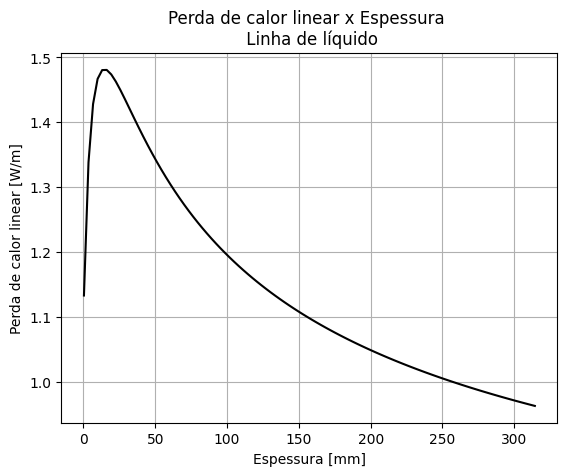

Coeficiente convectivo 2.7101461138783107 [W/mK]
q_adm 57.30553492961625
Perda de calor linear 1.0044789760002188 [W/m]
Espessura da linha de líquido 0.31750000000000006 [mm]


In [ ]:
linha_liquido(raio_ext_liquido,UR,T_amb,Pressao_liquido,vazao,L_liquido,subresfriamento)


T_amb 313.15
T_int 276.15
T_sup 308.6187850992256
r2_temp 0.015
Gr 13709.333382387566
Pr 0.7057403995956598
r2_temp 0.16597291778998458
Gr 18571810.656209506
Pr 0.7057403995956598
r2_temp 0.08165499708252275
Gr 2211519.959864824
Pr 0.7057403995956598
r2_temp 0.09355194493154384
Gr 3325837.4789241473
Pr 0.7057403995956598
r2_temp 0.0909675240078339
Gr 3057747.9431926
Pr 0.7057403995956598
r2_temp 0.09148563755024496
Gr 3110293.103551546
Pr 0.7057403995956598
r2_temp 0.09138002725223097
Gr 3099534.039853751
Pr 0.7057403995956598
r2_temp 0.005
Gr 507.7530882365767
Pr 0.7057403995956598
r2_temp 0.005495495495495496
Gr 674.1602301850509
Pr 0.7057403995956598
r2_temp 0.005990990990990991
Gr 873.4510275429813
Pr 0.7057403995956598
r2_temp 0.006486486486486486
Gr 1108.5904000604007
Pr 0.7057403995956598
r2_temp 0.006981981981981982
Gr 1382.5432674873423
Pr 0.7057403995956598
r2_temp 0.007477477477477477
Gr 1698.274549573839
Pr 0.7057403995956598
r2_temp 0.007972972972972973
Gr 2058.74916606992

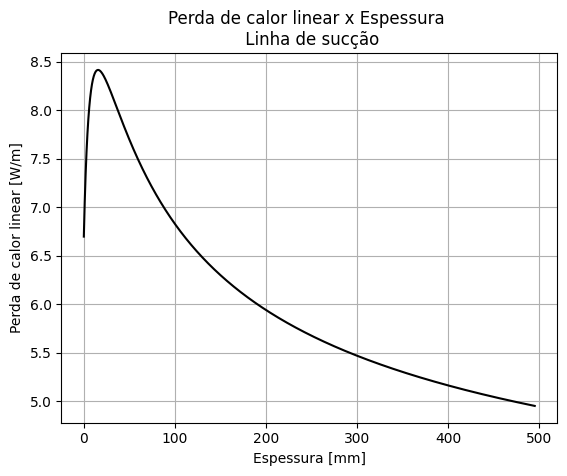

Temperatura de orvalho 33.46878509922561 [°C]
Coeficiente convectivo 2.280443801657999 [W/mK]
Perda de calor linear 7.020708317628112 [W/m]
Espessura da linha de sucção 86.40148210663952 [mm]


In [ ]:
espessura_succao = linha_succao(raio_ext_succao,UR,T_amb,T_int_succao)
espessura_succao